# pHunt - the _PromoterHunter_

This is an attempt at recoding in Python a version of the [PromoterHunter](http://www.phisite.org/main/index.php?nav=tools&nav_sel=hunter) tool.

Makes a few simplifications over the PromoterHunter PERL code:

- Processes only forward strand
- Does not compute a moving average for the Gibbs Free Energy unless requested
    - This is not used in promoter score computation, since it essentially amounts to double averaging


## GibbsFE

This function implements the computation of the Gibbs Free Energy of a DNA sequence. It does so by using a look-up-table for dinucleotide contributions to the Gibbs FE. The idea behind the computation of Gibbs FE for promoter prediction is that _"Regions with lower ΔG values are thermodynamically less stable. Prokaryotic promoters are usually localized in these regions."_

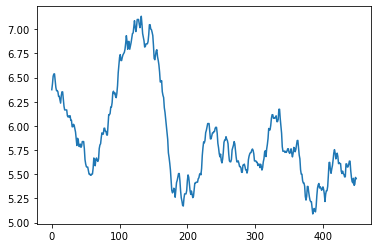

In [215]:
"""
GibbsFE: computes the Gibbs Free Energy of a DNA sequence
reads in:
- DNA sequence (BioPython Seq object)
- window length (to compute Free Energy over)
Assumes the DNA sequence only contains DNA characters (A, C, G, T)
"""
def GibbsFE(mySeq, wlen=None):
    mySeq = mySeq.upper()   #upper case sequence
    
    #define Gibbs Free Energy sequence components
    LUTfe = {
            'AA' : 4.18,
            'AC' : 6.02,
            'AG' : 5.36,
            'AT' : 3.68,
            'CA' : 6.07,
            'CC' : 7.70,
            'CG' : 9.08,
            'CT' : 5.36,
            'GA' : 5.44,
            'GC' : 9.37,
            'GG' : 7.70,
            'GT' : 6.02,
            'TA' : 2.43,
            'TC' : 5.44,
            'TG' : 6.07,
            'TT' : 4.18      
            }

    #convert sequence to vector
    myVec = []
    #return empty vector if sequence is less than 2 nucleotides
    mySeqlen = len(mySeq)
    if mySeqlen<2:
        return(myVec)
    #iterate over the sequence, grabbing two elements at time
    #with a +1 step size
    for p in range(mySeqlen-1):
        dinuc = mySeq[p]+mySeq[p+1]  #create dinucleotide
        myVec.append(LUTfe[dinuc])   #look up GE value in table
    
    #perform moving average, if requested (wlen!=None)
    if (wlen):
        myVeclen = len(myVec)
        #return original vector if window size over length
        if myVeclen<wlen:
            return(myVec)
        myMAvec = []
        for p in range(myVeclen-wlen+1):
            #compute average
            myMAvec.append(sum(myVec[p:p+wlen])/wlen)
        #return moving average vector
        return(myMAvec)
    else:
        return(myVec)
    
#print(LUTfe['AA'])
#    print(myVec)
#    print(myMAvec)

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

#create a sequence record
mydna = SeqRecord(Seq('TGAAGCGGTGGTGGAAGCCATTCGTCAGGGCAAACCGCTGGAAGATCTGCCGCTCAGTGAGTTGCAGAAATTCAGTCAGGTGATTGACGAAGATGTCTATCCGATTCTGTCGCTGCAATCGTGCCTCGACAAGCGTGCGGCAAAAGGCGGCGTCTCACCGCAGCAGGTGGCGCAGGCGATTGCTTTTGCGCAGGCTCGGTTAGGGTAAGAACATTTATATGTATAAATTTGAGCCTGGCTTATCGCCGGGCTTTTTTATGGCAAAAAAAAGCGGATCCTGGAGATCCGCAAAAGTTCACGTTGGCTTTAGTTATTCGAGTTGAGAAACTCTCGAAACGGGCAGTGACTTCAAGGGTTAAAAGAGGTGCCGCTCCGTTTCTGTGAGCAATTATCAGTCAGAATGCTTGATAGGGATAATCGTTCATTGCTATTCTACCTATCGCCATGAACTATCGTGGCGATGGAGGATGGATAATGAATATTCGTGATCTTGAGTACCT'),\
                        id='NC_000962.3:2925356-2925457',\
                        description='Mycobacterium tuberculosis H37Rv promoter sequence')    



#example usage
energies = GibbsFE(mydna,50)

#plot results
import matplotlib.pyplot as plt
plt.plot(energies)


## Promoter assessment

This function implements the assessment of putative promoter sequences in a DNA sequence. It look only at the forward strand. The function receives a sequence, two instantiated BioPython motif objects and a min/max spacer distance. It calls the GibbsFE function to obtain a vector of Gibbs Free Energy dinucleotide contributions. It will then return a list of the (5 default) best putative promoters, along with their score.

TTGACA
Thres: 0.03828859126248574
TATAAT
Thres: 1.9188231130852493
Range: 398 - 422 | 18 - L: 4.11 R: 5.22 FE: 0.51 T: 9.84 - S: TTATCAtcagaatgcttgataggGATAAT
Range: 87 - 110 | 17 - L: 5.72 R: 3.8 FE: 0.02 T: 9.54 - S: TTGACAatcgctgcaatcgtgcTATCGT
Range: 414 - 438 | 18 - L: 4.61 R: 3.02 FE: 0.34 T: 7.97 - S: TTGATAggataatcgttcattgaCATTCT
Range: 310 - 333 | 17 - L: 4.02 R: 3.31 FE: 0.19 T: 7.52 - S: TTGGCTtagttattcgagttgaGAAACT
Range: 459 - 480 | 15 - L: 1.01 R: 5.22 FE: 1.02 T: 7.24 - S: CTATCGggcgatggaggatgGATAAT
Range: 385 - 406 | 15 - L: 1.12 R: 4.48 FE: 0.49 T: 6.09 - S: TTTCTGgagcaattatcagtCAGAAT
Range: 61 - 83 | 16 - L: 4.3 R: 2.14 FE: -0.47 T: 5.97 - S: TTGCAGaattcagtcaggtgaTACCTT
Range: 209 - 233 | 18 - L: 0.6 R: 5.66 FE: -0.93 T: 5.33 - S: TTAGGGaagaacatttatatgtaTAAATT
Range: 439 - 460 | 15 - L: 0.37 R: 3.8 FE: 0.74 T: 4.91 - S: ATTCTActatcgccatgaacTATCGT
Range: 464 - 486 | 16 - L: 0.37 R: 2.81 FE: 1.13 T: 4.32 - S: GTGGCGtggaggatggataatGAATAT
Range: 462 - 486 | 18 - L: 0.29 R

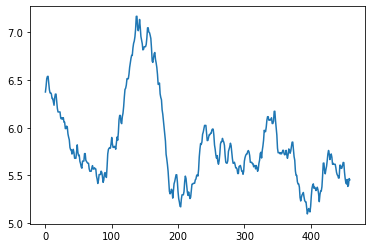

In [216]:
#import the Bio motifs module
from Bio import motifs

from math import log
from Bio.SeqUtils import GC as gc

"""
"""
def pHunt(mySeq, lmot, lthrs, rmot, rthrs, minD, maxD, scale=10, lerg=-100, rerg=30):
    GC = gc(mySeq)/100
    #score sequence with left motif
    lscrs=lmot.pssm.calculate(mySeq).tolist()
    #score sequence with left motif
    rscrs=rmot.pssm.calculate(mySeq).tolist()
    #compute the Gibbs Free Energy vector
    fes = GibbsFE(mySeq)
    #mean Gibbs Free Energy across entire sequence
    meanFE = sum(fes)/len(fes)
    
    #list of spacer-adequate high-scoring motif pairs
    hsmp = []
    
    mySeqlen = len(mySeq)
    #go through sequence, first with left PSSM
    for pl in range(mySeqlen-(lmot.pssm.length + minD + rmot.pssm.length)):
        #if score above threshold
        if lscrs[pl] > lthrs:
            remrange = pl+lmot.pssm.length+maxD+1 if (pl+lmot.pssm.length+maxD+1 < mySeqlen - rmot.pssm.length) else mySeqlen - rmot.pssm.length
            #go through sequence, now with right PSSM, up to spacer
            for pr in range(pl+lmot.pssm.length+minD,remrange):
                #if score above threshold
                if rscrs[pr] > rthrs:
                    element = {'lpos' : pl, 'lseq' : str(mySeq[pl:pl+lmot.pssm.length]),
                               'lscr' : lscrs[pl],
                               'rpos' : pr, 'rseq' : str(mySeq[pr:pr+rmot.pssm.length]),
                               'rscr' : rscrs[pr],
                               'mscr' : lscrs[pl] + rscrs[pr],
                               'spcr' : str(mySeq[pl+lmot.pssm.length+1:pr].lower())
                              }
                    #add Gibbs Free Energy component
                    #as average betweeen coordinates (plus lerg, rerg margins)
                    lrange = pr+lerg if pr+lerg>0 else 0
                    rrange = pr+rerg if pr+rerg<mySeqlen-rmot.pssm.length else mySeqlen-rmot.pssm.length
                    escr = (sum(fes[lrange:rrange])/(rrange-lrange))
                    
                    element['escr'] = scale * log(meanFE/escr,2)
                    element['fscr'] = element['mscr'] + element['escr']
                    
                    hsmp.append(element)
                    
    #return list of spacer-adequate high-scoring motif pairs
    return(hsmp)
                    
        
        
    
#example usage

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#create a sequence record
mydna = SeqRecord(Seq('TGAAGCGGTGGTGGAAGCCATTCGTCAGGGCAAACCGCTGGAAGATCTGCCGCTCAGTGAGTTGCAGAAATTCAGTCAGGTGATACCTTGACATATCGCTGCAATCGTGCTATCGTAAAAGATGTCTATCCGATTCTAGCAAGCGTGCGGCAAAAGGCGGCGTCTCACCGCAGCAGGTGGCGCAGGCGATTGCTTTTGCGCAGGCTCGGTTAGGGTAAGAACATTTATATGTATAAATTTGAGCCTGGCTTATCGCCGGGCTTTTTTATGGCAAAAAAAAGCGGATCCTGGAGATCCGCAAAAGTTCACGTTGGCTTTAGTTATTCGAGTTGAGAAACTCTCGAAACGGGCAGTGACTTCAAGGGTTAAAAGAGGTGCCGCTCCGTTTCTGTGAGCAATTATCAGTCAGAATGCTTGATAGGGATAATCGTTCATTGACATTCTACCTATCGCCATGAACTATCGTGGCGATGGAGGATGGATAATGAATATTCGTGATCTTGAGTACCT'),\
                        id='NC_000962.3:2925356-2925457',\
                        description='Mycobacterium tuberculosis H37Rv promoter sequence')    

from Bio import SeqIO
#read in motif 1 instances, create motif and define threshold
motif_seqs = SeqIO.parse('Eco-10.fas','fasta')
motif_instances = [s.seq for s in motif_seqs]
m2 = motifs.create(motif_instances, 'ACGT')
m2._pseudocounts = 0.05
t2 = m2.pssm.distribution(precision=10**3).threshold_patser()

#read in motif 2 instances, create motif and define threshold
motif_seqs = SeqIO.parse('Eco-35.fas','fasta')
motif_instances = [s.seq for s in motif_seqs]
m1 = motifs.create(motif_instances, 'ACGT')
m1._pseudocounts = 0.05
t1 = m1.pssm.distribution(precision=10**3).threshold_patser()

print(m1.consensus)
print('Thres:',t1)
print(m2.consensus)
print('Thres:',t2)

plt.plot(GibbsFE(mydna.seq,50)) 

mypromoters = pHunt(mydna.seq, m1, t1, m2, t2, 15, 18)

mypromoters = sorted(mypromoters, key = lambda k: k['fscr'], reverse=True)

for promoter in mypromoters:
    print('Range:', promoter['lpos'],'-',promoter['rpos'], '|', promoter['rpos']-promoter['lpos']-6, \
          '- L:',round(promoter['lscr'],2),'R:',round(promoter['rscr'],2),\
          'FE:',round(promoter['escr'],2),'T:',round(promoter['fscr'],2),\
         '- S:',promoter['lseq']+promoter['spcr']+promoter['rseq'])
